# Video Search Demo

This notebook demonstrates building a searchable video index using Pixeltable:
1. Extract audio from videos
2. Split audio into chunks for transcription
3. Break transcriptions into sentences for embedding-based search

## Pipeline Overview

**Base Table:** `skates`
- Stores videos
- Computed column: audio extracted from video

**View 1:** `audio_chunks`
- Splits audio into 15-second segments for transcription

**View 2:** `sentences` (to be added)
- Splits transcripts into sentences for semantic search

## Setup

In [22]:
import pixeltable as pxt
import pixeltable.functions as pxtf
import os
import getpass

In [23]:
# Set OpenAI API key if not already in environment
if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter your OpenAI API key:')

In [24]:
# Uncomment to clean working space
pxt.drop_dir('olympics', force=True, if_not_exists='ignore')

In [25]:
pxt.create_dir('olympics')

Created directory 'olympics'.


## Base table

In [26]:
# Create a table with a video column
t = pxt.create_table('olympics.skates', schema={'video': pxt.Video}, if_exists='replace_force')

Created table 'skates'.


In [27]:
# Insert the videos
t.insert([
    {'video': 'https://github.com/apreshill/pxt-d2/raw/refs/heads/main/media/olympics-malinin.mp4'}
])

Inserted 1 row with 0 errors in 1.39 s (0.72 rows/s)


1 row inserted.

In [28]:
t

table 'olympics/skates'

 Column Name   Type Computed With Comment
       video  Video

video
""

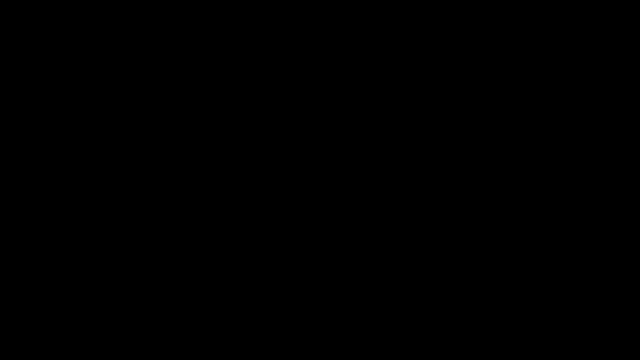

In [29]:
t.collect()

In [30]:
# get the audio file, save in a column
t.add_computed_column(audio=pxtf.video.extract_audio(t.video, format='wav'))

Added 1 column value with 0 errors in 0.36 s (2.78 rows/s)


1 row updated.

In [31]:
t

table 'olympics/skates'

 Column Name   Type                       Computed With Comment
       video  Video                                            
       audio  Audio  extract_audio(video, format='wav')

## View 1: Audio segments

In [32]:
ac_view = pxt.create_view(
    'olympics.audio_chunks',
    t,
    iterator=pxtf.audio.audio_splitter(
        audio=t.audio,
        chunk_duration_sec=15.0
    ),
    if_exists='replace'
 )

In [33]:
ac_view

view 'olympics/audio_chunks' (of 'olympics/skates')

     Column Name             Type                       Computed With Comment
             pos    Required[Int]                                            
  start_time_sec  Required[Float]                                            
    end_time_sec  Required[Float]                                            
     audio_chunk            Audio                                            
           video            Video                                            
           audio            Audio  extract_audio(video, format='wav')

In [34]:
ac_view.count()

28

In [35]:
ac_view.add_computed_column(
    transcript=pxtf.openai.transcriptions(
        ac_view.audio_chunk, model='whisper-1', model_kwargs={'language': 'en'}
    )
)

Added 28 column values with 0 errors in 7.15 s (3.91 rows/s)


28 rows updated.

In [36]:
# Extract text from transcript JSON and cast to a String
ac_view.add_computed_column(transcript_text=ac_view.transcript.text.astype(pxt.String))

Added 28 column values with 0 errors in 0.06 s (500.52 rows/s)


28 rows updated.

In [37]:
ac_view

view 'olympics/audio_chunks' (of 'olympics/skates')

      Column Name             Type                                      Computed With Comment
              pos    Required[Int]                                                           
   start_time_sec  Required[Float]                                                           
     end_time_sec  Required[Float]                                                           
      audio_chunk            Audio                                                           
       transcript             Json  transcriptions(audio_chunk, model='whisper-1',...        
  transcript_text           String                     transcript.text.astype(String)        
            video            Video                                                           
            audio            Audio                 extract_audio(video, format='wav')

In [38]:
# show the transcript text
ac_view.select(ac_view.pos, ac_view.transcript_text).head()

pos,transcript_text
0,"A bit of a shaky start, then a team goal, a glimpse of what is possible in the short and now a stage that is his to grasp a moment, make a statement."
1,and win gold. Elia Maliner. The only true wisdom is in knowing
2,You know nothing The lost Is in the unknown
3,Embrace the storm.
4,"Effortless start, quad flip, if he does attempt the quad axel it will be the next element."
5,"This is a jump that the sport once considered impossible. The only skater to land this. He was going for it, just a single."
6,What? What? What? What? What?
7,Second most difficult quad.
8,"Was going for a quad loop, only a double. We don't usually see Ilia make mistakes like this."
9,"You are something, but not nothing."


## View 2: Sentences


In [39]:
sent_view = pxt.create_view(
    'olympics.transcript_chunks',
    ac_view,
    iterator=pxtf.string.string_splitter(
        ac_view.transcript_text, separators='sentence'
    ),
    if_exists='replace'
)

pos,text,start_time_sec,end_time_sec,audio_chunk,transcript,transcript_text,video,audio
0,"A bit of a shaky start, then a team goal, a glimpse of what is possible in the short and now a stage that is his to grasp a moment, make a statement.",0.,15.019,,"{""text"": ""A bit of a shaky start, then a team goal, a glimpse of what is possible in the short and now a stage that is his to grasp a moment, make a statement."", ""usage"": {""type"": ""duration"", ""seconds"": 16.}, ""logprobs"": null}","A bit of a shaky start, then a team goal, a glimpse of what is possible in the short and now a stage that is his to grasp a moment, make a statement.",,
0,and win gold.,15.,30.019,,"{""text"": ""and win gold. Elia Maliner. The only true wisdom is in knowing"", ""usage"": {""type"": ""duration"", ""seconds"": 16.}, ""logprobs"": null}",and win gold. Elia Maliner. The only true wisdom is in knowing,,
1,Elia Maliner.,15.,30.019,,"{""text"": ""and win gold. Elia Maliner. The only true wisdom is in knowing"", ""usage"": {""type"": ""duration"", ""seconds"": 16.}, ""logprobs"": null}",and win gold. Elia Maliner. The only true wisdom is in knowing,,

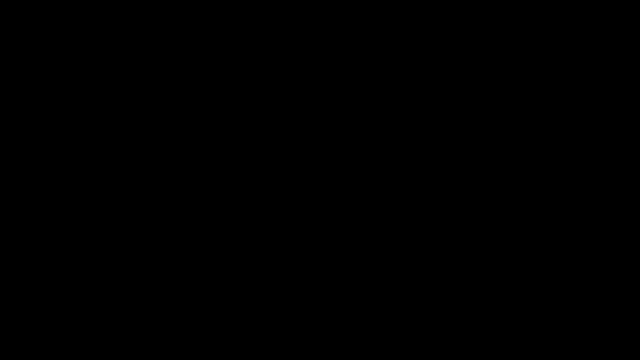
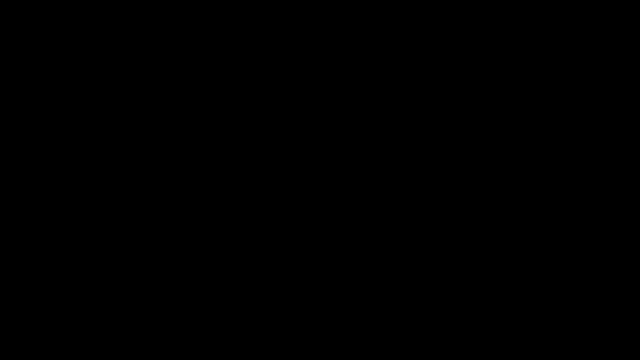
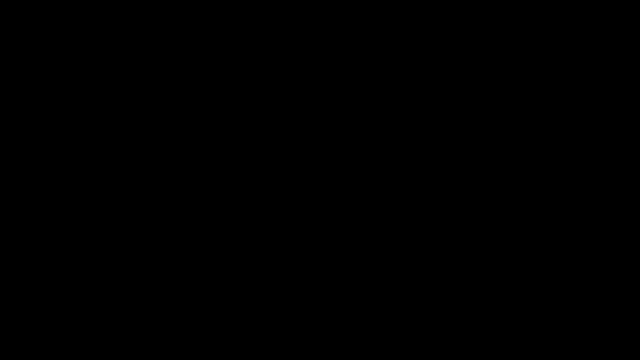

In [40]:
sent_view.head(3)

In [41]:
sent_view.add_embedding_index(
    sent_view.text,
    embedding=pxtf.huggingface.sentence_transformer.using(model_id='sentence-transformers/all-mpnet-base-v2')
)

In [42]:
sent_view

view 'olympics/transcript_chunks' (of 'olympics/audio_chunks', 'olympics/skates')

      Column Name              Type                                      Computed With Comment
              pos     Required[Int]                                                           
             text  Required[String]                                                           
   start_time_sec   Required[Float]                                                           
     end_time_sec   Required[Float]                                                           
      audio_chunk             Audio                                                           
       transcript              Json  transcriptions(audio_chunk, model='whisper-1',...        
  transcript_text            String                     transcript.text.astype(String)        
            video             Video                                                           
            audio             Audio                 extract_audio(video, format='wav')        

 Index Name Column  Metric                                          Embedding
       idx0   text  cosine  sentence_transformer(text, model_id='sentence-...